In [2]:
import numpy as np
import mindspore as ms
import mindspore.nn as nn
import mindspore.ops as ops

class RevIN(nn.Cell):
    def __init__(self, num_features: int, eps=1e-5, affine=True):
        """
        :param num_features: the number of features or channels
        :param eps: a value added for numerical stability
        :param affine: if True, RevIN has learnable affine parameters
        """
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        if self.affine:
            self._init_params()

    def construct(self, x, mode: str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else:
            raise NotImplementedError
        return x

    def _init_params(self):
        # initialize RevIN params: (C,)
        self.affine_weight = ms.Parameter(ms.Tensor(np.ones(self.num_features), ms.float32))
        self.affine_bias = ms.Parameter(ms.Tensor(np.zeros(self.num_features), ms.float32))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim - 1))
        self.mean = ops.ReduceMean(keep_dims=True)(x, dim2reduce)
        self.stdev = ops.Sqrt()(ops.ReduceMean(keep_dims=True)(ops.Square()(x - self.mean), dim2reduce) + self.eps)

    def _normalize(self, x):
        x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps * self.eps)
        x = x * self.stdev
        x = x + self.mean
        return x

# 示例使用
x = ms.Tensor(np.random.randn(10, 5, 5), ms.float32)
revin = RevIN(num_features=5)
normalized_x = revin.construct(x, mode='norm')
denormalized_x = revin.construct(normalized_x, mode='denorm')

print(normalized_x)
print(denormalized_x)


[[[ 0.9301133   0.10996535  0.5651733   0.5699522  -0.16793624]
  [-0.25311312 -0.4582787   0.34518972  0.8658941   0.7707193 ]
  [ 0.7875185  -0.9857868  -0.7798234  -0.3520448   1.4832159 ]
  [-1.8226837  -0.5404636  -1.4696834  -1.8095542  -1.0106806 ]
  [ 0.35816503  1.8745638   1.3391438   0.7257527  -1.0753185 ]]

 [[ 0.03615843  0.90329623 -0.5682593  -1.5221734   1.7967819 ]
  [ 0.7187547   0.8890289  -0.34101498 -0.7803906  -0.46328738]
  [-1.8301255   0.6350106  -1.1774012   0.58607584 -0.29569605]
  [ 0.01099658 -1.0647651   0.33717424  1.2168696  -1.2011522 ]
  [ 1.0642157  -1.3625705   1.7495013   0.4996184   0.16335368]]

 [[ 0.06661642 -0.776541    1.9573009   0.8266131  -0.7385906 ]
  [ 1.720451    1.3019683  -0.7491852  -0.12639539  0.7553886 ]
  [-1.201617    1.1020199  -0.1186249   0.8085023   0.6235845 ]
  [ 0.16564144 -1.0991309  -0.5481843   0.36566657  0.9623732 ]
  [-0.7510917  -0.5283164  -0.541306   -1.8743865  -1.6027558 ]]

 [[ 0.5324285   1.2385993   0.4295

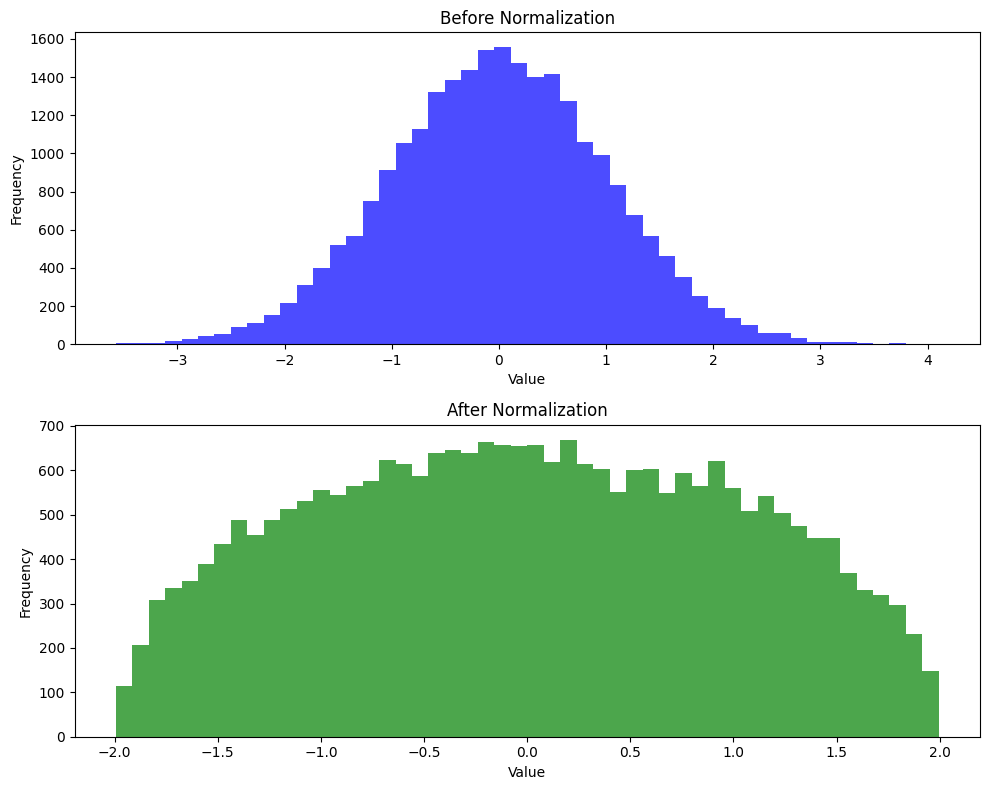

In [3]:
import numpy as np
import mindspore as ms
import mindspore.nn as nn
import mindspore.ops as ops
import matplotlib.pyplot as plt

class RevIN(nn.Cell):
    def __init__(self, num_features: int, eps=1e-5, affine=True):
        """
        :param num_features: the number of features or channels
        :param eps: a value added for numerical stability
        :param affine: if True, RevIN has learnable affine parameters
        """
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        if self.affine:
            self._init_params()

    def construct(self, x, mode: str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else:
            raise NotImplementedError
        return x

    def _init_params(self):
        # initialize RevIN params: (C,)
        self.affine_weight = ms.Parameter(ms.Tensor(np.ones(self.num_features), ms.float32))
        self.affine_bias = ms.Parameter(ms.Tensor(np.zeros(self.num_features), ms.float32))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim - 1))
        self.mean = ops.ReduceMean(keep_dims=True)(x, dim2reduce)
        self.stdev = ops.Sqrt()(ops.ReduceMean(keep_dims=True)(ops.Square()(x - self.mean), dim2reduce) + self.eps)

    def _normalize(self, x):
        x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps * self.eps)
        x = x * self.stdev
        x = x + self.mean
        return x

# 示例数据
data = np.random.randn(1000, 5, 5).astype(np.float32)  # 生成随机数据
x = ms.Tensor(data, ms.float32)
revin = RevIN(num_features=5)

# 归一化
normalized_x = revin.construct(x, mode='norm')
# 转换为NumPy数组以便于绘图
normalized_data = normalized_x.asnumpy()

# 绘制归一化前后的数据分布
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# 归一化前
axs[0].hist(data.flatten(), bins=50, color='blue', alpha=0.7)
axs[0].set_title('Before Normalization')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')

# 归一化后
axs[1].hist(normalized_data.flatten(), bins=50, color='green', alpha=0.7)
axs[1].set_title('After Normalization')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()
